In [1]:
! pip install gurobipy


[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from gurobipy import *
import pandas as pd
import numpy as np

# Minimisons la disruption

La disruption sera définie comme la somme des nouveaux workloads pour les SR (pas sortants)

## V1 : la disruption totale

In [3]:
initial_bricks = {
    0: {'center_brick': 4, 'assigned_bricks': [4, 5, 6, 7, 8, 15]},
    1 : {'center_brick': 14, 'assigned_bricks': [10, 11, 12, 13, 14]},
    2 : {'center_brick': 16, 'assigned_bricks': [9, 16, 17, 18]},
    3 : {'center_brick': 22, 'assigned_bricks': [1, 2, 3, 19, 20, 21, 22]}
}


# Read the CSV file
bricks_df = pd.read_csv('bricks_index_values.csv')

# Extract bricks and their index values
bricks = bricks_df['brick'].tolist()
index_values = bricks_df['index_value'].tolist()

brick_values = dict(zip(bricks, index_values))
print(brick_values)
print(bricks)


{1: 0.1609, 2: 0.1164, 3: 0.1026, 4: 0.1516, 5: 0.0939, 6: 0.132, 7: 0.0687, 8: 0.093, 9: 0.2116, 10: 0.2529, 11: 0.0868, 12: 0.0828, 13: 0.0975, 14: 0.8177, 15: 0.4115, 16: 0.3795, 17: 0.071, 18: 0.0427, 19: 0.1043, 20: 0.0997, 21: 0.1698, 22: 0.2531}
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]


In [4]:
def mono_disruptive(bricks, index_values, initial_bricks, workload_range= [0.8, 1.2]):
    # Number of bricks and groups
    num_bricks = len(bricks)
    num_groups = len(initial_bricks)

    # Create a new model
    m = Model("BrickGrouping")

    # Create variables: x[i, j] = 1 if brick i-1 is assigned to group j, 0 otherwise
    x = m.addVars(num_bricks, num_groups, vtype=GRB.BINARY, name="x")

    # Add constraints: each brick must be assigned to exactly one group
    for i in range(num_bricks):
        m.addConstr(quicksum(x[i, j] for j in range(num_groups)) == 1)

    # Add constraints: the sum of index values in each group must be between 0.8 and 1.2
    for j in range(num_groups):
        # in index values, the brick i has the index value [i - 1], same for x[i, j]
        m.addConstr(quicksum(index_values[i] * x[i, j] for i in range(num_bricks)) >= workload_range[0])
        m.addConstr(quicksum(index_values[i] * x[i, j] for i in range(num_bricks)) <= workload_range[1])

    # Minimize the total change of assigned bricks 
    total_change = quicksum((index_values[brick] * (1 - x[brick, group])) for group in initial_bricks for brick in range(num_bricks) if brick+1 in initial_bricks[group]['assigned_bricks'])
    m.setObjective(total_change, GRB.MINIMIZE)

    m.params.outputflag = 0
    
    # Optimize the model
    m.optimize()
    

    # Extract the solution
    groups = [[] for _ in range(num_groups)]
    for i in range(num_bricks):
        for j in range(num_groups):
            if x[i, j].x > 0.5:
                groups[j].append(i+1)
    return groups, total_change.getValue()

In [5]:
# Result of optimization

final_groups, change_sum = mono_disruptive(bricks, index_values, initial_bricks)

num_groups = len(final_groups)

# Print the groups
for j in range(num_groups):
    print(f"Group {j+1}: {final_groups[j]}")

Set parameter Username
Set parameter LicenseID to value 2601819
Academic license - for non-commercial use only - expires 2025-12-18
Group 1: [4, 5, 6, 7, 8, 15]
Group 2: [10, 13, 14]
Group 3: [9, 11, 12, 16, 17, 18]
Group 4: [1, 2, 3, 19, 20, 21, 22]


### Fonctions pour montrer les solutions

In [6]:
def show_load_change(final_groups, brick_values):
    # Calculate and print the brick load of each group
    for j in range(len(final_groups)):
        brick_load = sum(brick_values[brick] for brick in final_groups[j])
        print(f"Group {j+1} brick load: {brick_load}")
    print(f"Total change in brick values: {change_sum}")

def show_brick_changes(initial_bricks, final_groups, bricks):
    # Create a dictionary to map each brick to its initial group
    initial_group_map = {}
    for group, data in initial_bricks.items():
        for brick in data['assigned_bricks']:
            initial_group_map[brick] = group

    # Create a dictionary to map each brick to its final group
    final_group_map = {}
    for group, bricks_in_group in enumerate(final_groups):
        for brick in bricks_in_group:
            final_group_map[brick] = group

    # Compare the initial and final groups for each brick
    for brick in bricks:
        initial_group = initial_group_map.get(brick)
        final_group = final_group_map.get(brick)
        if initial_group != final_group:
            print(f"Brick {brick} has changed from Group {initial_group + 1} to Group {final_group + 1}")


In [7]:
show_load_change(final_groups, brick_values)

Group 1 brick load: 0.9507
Group 2 brick load: 1.1681
Group 3 brick load: 0.8744000000000001
Group 4 brick load: 1.0068
Total change in brick values: 0.1695999999999988


In [8]:
# # Calculate and print the brick value change of each group
# for j in range(num_groups):
#     initial_value = sum(brick_values[brick] for brick in initial_bricks[j]['assigned_bricks'])
#     optimized_value = sum(brick_values[brick] for brick in final_groups[j])
#     value_change = optimized_value - initial_value
#     print(f"Group {j+1} brick value change: {value_change}")

#     # Calculate the sum of the values of the bricks that are newly here
#     new_bricks_value = sum(brick_values[brick] for brick in final_groups[j] if brick not in initial_bricks[j]['assigned_bricks'])
#     print(f"Group {j+1} new bricks value: {new_bricks_value}")

# # Print which brick has changed from where to where
# for i in range(4):
#     initial_group = next((group for group in initial_bricks if bricks[i] in initial_bricks[group]['assigned_bricks']), None)
#     optimized_group = next((j for j in range(num_groups) if x[i, j].x > 0.5), None)
#     if initial_group is not None and optimized_group is not None and initial_group != optimized_group:
#         print(f"Brick {bricks[i]} has changed from Group {initial_group+1} to Group {optimized_group+1}")

## V2 : disruption minimale par RP

In [9]:
def minimize_max_new_brick_value(bricks, index_values, initial_bricks, workload_range=[0.8, 1.2]):
    """
    Bricks : list of brick indexes
    index_values : list of index_value, 1 by brick
    initial_bricks : dict of initial groups, with center_brick and assigned_bricks
    """
    # Number of bricks and groups
    num_bricks = len(bricks)
    num_groups = len(initial_bricks)

    # Create a new model
    m = Model("BrickGrouping")

    # Create variables: x[i, j] = 1 if brick i-1 is assigned to group j, 0 otherwise
    x = m.addVars(num_bricks, num_groups, vtype=GRB.BINARY, name="x")

    # Create a variable for the maximum new brick value
    max_new_value = m.addVar(vtype=GRB.CONTINUOUS, name="max_new_value")

    # Add constraints: each brick must be assigned to exactly one group
    for i in range(num_bricks):
        m.addConstr(quicksum(x[i, j] for j in range(num_groups)) == 1)

    # Add constraints: the sum of index values in each group must be between 0.8 and 1.2
    for j in range(num_groups):
        m.addConstr(quicksum(index_values[i] * x[i, j] for i in range(num_bricks)) >= workload_range[0])
        m.addConstr(quicksum(index_values[i] * x[i, j] for i in range(num_bricks)) <= workload_range[1])

    # Add constraints to ensure max_new_value is greater than or equal to the new brick value for each group
    for j in range(num_groups):
        new_brick_value = quicksum(index_values[brick] * x[brick, j] for brick in range(num_bricks) if brick + 1 not in initial_bricks[j]['assigned_bricks'])
        m.addConstr(max_new_value >= new_brick_value)

    # Minimize the maximum new brick value
    m.setObjective(max_new_value, GRB.MINIMIZE)
    
    m.params.outputflag = 0

    # Optimize the model
    m.optimize()

    # Extract the solution
    groups = [[] for _ in range(num_groups)]
    for i in range(num_bricks):
        for j in range(num_groups):
            if x[i, j].x > 0.5:
                groups[j].append(i + 1)
    return groups, max_new_value.x


In [10]:
min_max_group, max_change = minimize_max_new_brick_value(bricks, index_values, initial_bricks)

In [11]:
show_load_change(min_max_group, brick_values)

Group 1 brick load: 0.9507
Group 2 brick load: 1.1574
Group 3 brick load: 0.8023
Group 4 brick load: 1.0896
Total change in brick values: 0.1695999999999988


In [12]:
# Example usage
show_brick_changes(initial_bricks, min_max_group, bricks)

Brick 12 has changed from Group 2 to Group 4
Brick 13 has changed from Group 2 to Group 3


In [13]:
show_brick_changes(initial_bricks, final_groups, bricks)

Brick 11 has changed from Group 2 to Group 3
Brick 12 has changed from Group 2 to Group 3


# Minimisons la distance

## Minimisation de la distance par RP

In [14]:
bricks_df = pd.read_csv('bricks_index_values.csv',index_col=0)
bricks_loads = bricks_df.to_numpy() # initial_values

distances_to_rp = pd.read_csv('brick_rp_distances.csv', index_col=0)
distances_to_rp = distances_to_rp.to_numpy().T
print("ditance_to_rp shape:",distances_to_rp.shape)
print("brick_loads shape:",bricks_loads.shape)

ditance_to_rp shape: (4, 22)
brick_loads shape: (22, 1)


In [15]:
def optimize_brick_distances(distance_to_rp, bricks_loads):
    # Create a new model
    m = Model("brick")

    # Create variables
    x = m.addVars(22, 4, vtype=GRB.BINARY, name="x")
    # Set objective
    z = m.addVar(name="z")

    m.update()
    # Set constraints
    m.addConstrs((sum(x[i, j] for j in range(4)) == 1 for i in range(22)))
    m.addConstrs((sum(bricks_loads[i,0] * x[i, j] for i in range(22)) <= 1.2 for j in range(4)))
    m.addConstrs((sum(bricks_loads[i,0] * x[i, j] for i in range(22)) >= 0.8 for j in range(4)))
    m.addConstrs((z >= sum(distance_to_rp[j, i] * x[i, j] for i in range(22)) for j in range(4)))

    # Set objective
    m.setObjective(z, GRB.MINIMIZE)
    
    m.params.outputflag = 0

    m.optimize()

    # Print solution
    if m.status == GRB.OPTIMAL:
        print("\nSolution optimale trouvée :")
        print("Valeur de z :", z.X)
        print("\nMatrice x (assignations) :")
        x_matrix = [[x[i, j].X for j in range(4)] for i in range(22)]
        for i, row in enumerate(x_matrix):
            print(f"i={i}: {row}")
    else:
        print("Aucune solution optimale trouvée.")
    # Extract the groups of bricks
    groups = [[] for _ in range(4)]
    for i in range(22):
        for j in range(4):
            if x[i, j].X > 0.5:
                groups[j].append(i + 1)
    return groups, m, z.X


roups, m, max_dist = optimize_brick_distances(distances_to_rp, bricks_loads)




Solution optimale trouvée :
Valeur de z : 56.0

Matrice x (assignations) :
i=0: [1.0, -0.0, -0.0, -0.0]
i=1: [-0.0, -0.0, 1.0, -0.0]
i=2: [0.0, -0.0, -0.0, 1.0]
i=3: [1.0, 0.0, -0.0, -0.0]
i=4: [-0.0, -0.0, 1.0, -0.0]
i=5: [1.0, 0.0, -0.0, -0.0]
i=6: [0.0, -0.0, 1.0, -0.0]
i=7: [-0.0, 1.0, -0.0, -0.0]
i=8: [1.0, -0.0, -0.0, -0.0]
i=9: [-0.0, -0.0, 1.0, -0.0]
i=10: [-0.0, 0.0, 1.0, -0.0]
i=11: [1.0, 0.0, -0.0, -0.0]
i=12: [-0.0, 1.0, 0.0, -0.0]
i=13: [-0.0, 0.0, -0.0, 1.0]
i=14: [-0.0, 1.0, 0.0, -0.0]
i=15: [-0.0, 0.0, 1.0, -0.0]
i=16: [-0.0, -0.0, 1.0, -0.0]
i=17: [-0.0, 1.0, -0.0, -0.0]
i=18: [-0.0, 1.0, 0.0, -0.0]
i=19: [-0.0, 1.0, 0.0, -0.0]
i=20: [1.0, 0.0, -0.0, -0.0]
i=21: [-0.0, -0.0, -0.0, 1.0]


# Epsilon constraint method

## Algorithme pour l'optimisation

In [16]:

def epsilon_constraint_scheme(bricks, index_values, initial_bricks, distance_to_rp, bricks_loads, workload_range=[0.8, 1.2]):
    """
    Implement the epsilon constraint scheme to find the set of all non-dominant solutions.
    """
    # Number of bricks and groups
    num_bricks = len(bricks)
    num_groups = len(initial_bricks)

    non_dominant_solutions = []

    # Start with epsilon as infinity
    epsilon = np.inf

    while epsilon > 0:
        # Create a new model
        # print("epsilon : ", epsilon)
        m = Model("EpsilonConstraint")

        # Create variables: x[i, j] = 1 if brick i-1 is assigned to group j, 0 otherwise
        x = m.addVars(num_bricks, num_groups, vtype=GRB.BINARY, name="x")

        # Create a variable for the maximum new brick value
        max_new_value = m.addVar(vtype=GRB.CONTINUOUS, name="max_new_value")

        # Add constraints: each brick must be assigned to exactly one group
        for i in range(num_bricks):
            m.addConstr(quicksum(x[i, j] for j in range(num_groups)) == 1)

        # Add constraints: the sum of index values in each group must be between 0.8 and 1.2
        for j in range(num_groups):
            m.addConstr(quicksum(index_values[i] * x[i, j] for i in range(num_bricks)) >= workload_range[0])
            m.addConstr(quicksum(index_values[i] * x[i, j] for i in range(num_bricks)) <= workload_range[1])

        # Add constraints to ensure max_new_value is greater than or equal to the new brick value for each group
        for j in range(num_groups):
            new_brick_value = quicksum(index_values[brick] * x[brick, j] for brick in range(num_bricks) if brick + 1 not in initial_bricks[j]['assigned_bricks'])
            m.addConstr(max_new_value >= new_brick_value)

        # Add epsilon constraint for the distance objective
        for j in range(num_groups):
            m.addConstr(quicksum(distance_to_rp[j, i] * x[i, j] for i in range(num_bricks)) <= epsilon)

        # Minimize the maximum new brick value
        m.setObjective(max_new_value, GRB.MINIMIZE)
        
        m.params.Outputflag = 0

        # Optimize the model
        m.optimize()

        # Extract the solution
        if m.status == GRB.OPTIMAL:
            groups = [[] for _ in range(num_groups)]
            for i in range(num_bricks):
                for j in range(num_groups):
                    if x[i, j].x > 0.5:
                        groups[j].append(i + 1)
            # print("Solution optimale trouvée pour cet epsilon :", groups)
            non_dominant_solutions.append((groups, max_new_value.x, epsilon))

            # Update epsilon to the new value of the constraint minus 0.01
            epsilon = np.max([quicksum(distance_to_rp[j, i] * x[i, j] for i in range(num_bricks)).getValue() for j in range(num_groups)]) - 0.01
        else:
            break

    return non_dominant_solutions


In [17]:

# Example usage
non_dominant_solutions = epsilon_constraint_scheme(bricks, index_values, initial_bricks, distances_to_rp, bricks_loads)

# Print the non-dominant solutions
for solution in non_dominant_solutions:
    groups, max_new_value, epsilon = solution
    print(f"Epsilon: {epsilon}, Max New Brick Value: {max_new_value}")
    for j in range(len(groups)):
        print(f"Group {j+1}: {groups[j]}")

Epsilon: inf, Max New Brick Value: 0.0974999999999997
Group 1: [4, 5, 6, 7, 8, 15]
Group 2: [10, 11, 14]
Group 3: [9, 13, 16, 17, 18]
Group 4: [1, 2, 3, 12, 19, 20, 21, 22]
Epsilon: 164.59000000000003, Max New Brick Value: 0.0975
Group 1: [4, 5, 6, 7, 8, 11, 15]
Group 2: [10, 12, 14]
Group 3: [9, 13, 16, 17, 18]
Group 4: [1, 2, 3, 19, 20, 21, 22]
Epsilon: 124.73, Max New Brick Value: 0.1696
Group 1: [4, 5, 6, 7, 8, 11, 12, 15]
Group 2: [10, 14, 20]
Group 3: [9, 13, 16, 17, 18]
Group 4: [1, 2, 3, 19, 21, 22]
Epsilon: 101.52, Max New Brick Value: 0.1696
Group 1: [4, 5, 6, 7, 8, 11, 12, 15]
Group 2: [10, 14, 19]
Group 3: [9, 13, 16, 17, 18]
Group 4: [1, 2, 3, 20, 21, 22]
Epsilon: 99.33, Max New Brick Value: 0.1698
Group 1: [4, 5, 6, 7, 8, 11, 12, 15]
Group 2: [10, 13, 14]
Group 3: [9, 16, 17, 18, 21]
Group 4: [1, 2, 3, 19, 20, 22]
Epsilon: 99.3, Max New Brick Value: 0.18430000000000002
Group 1: [4, 5, 6, 7, 8, 11, 13, 15]
Group 2: [10, 14, 19]
Group 3: [9, 12, 16, 17, 18, 20]
Group 4: [1,

[np.float64(164.6), np.float64(124.74000000000001), np.float64(101.53), np.float64(99.34), np.float64(99.31), np.float64(76.13), np.float64(75.00999999999999), np.float64(70.32), np.float64(69.44999999999999), np.float64(66.55), np.float64(64.99000000000001), np.float64(62.919999999999995), np.float64(62.769999999999996), np.float64(61.339999999999996), np.float64(61.150000000000006), np.float64(58.209999999999994), np.float64(57.66999999999999), np.float64(56.66), np.float64(56.0)]
[np.float64(171.88), np.float64(168.05), np.float64(164.6), np.float64(146.93), np.float64(144.84), np.float64(124.74000000000001), np.float64(101.53), np.float64(99.34), np.float64(98.97), np.float64(96.96000000000001), np.float64(93.16999999999999), np.float64(91.94999999999999), np.float64(88.19), np.float64(83.88), np.float64(78.80000000000001), np.float64(75.00999999999999), np.float64(73.97999999999999), np.float64(73.74), np.float64(70.25999999999999), np.float64(69.54), np.float64(68.02), np.float64

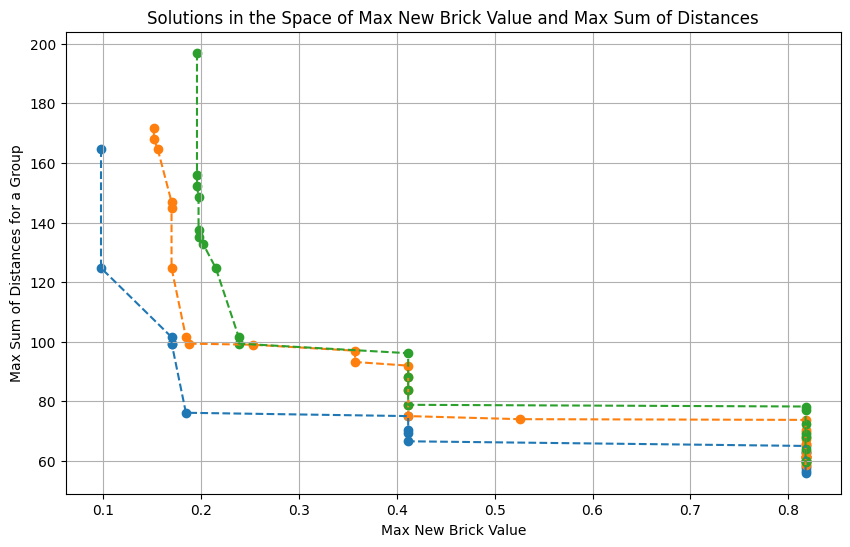

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

for workload_range,color in zip([(0.8,1.2),(0.85,1.15),(0.9,1.1)],["tab:blue","tab:orange","tab:green"]):
    
    non_dominant_solutions = epsilon_constraint_scheme(bricks, index_values, initial_bricks, distances_to_rp, bricks_loads, workload_range=workload_range)
    
    
    # Extract the max_new_value and epsilon from non_dominant_solutions
    max_new_values = [solution[1] for solution in non_dominant_solutions]
    epsilons = [solution[2] for solution in non_dominant_solutions]
    # Calculate the max sum of distances for each solution
    max_sum_distances = []
    for solution in non_dominant_solutions:
        groups = solution[0]
        max_sum_distance = np.max( [np.sum( [distances_to_rp[j, brick-1] for brick in group] ) for j, group in enumerate(groups) ])
        max_sum_distances.append(max_sum_distance)
    print( max_sum_distances)

    # Create the second plot
    plt.scatter(max_new_values, max_sum_distances, color=color)
    plt.plot(max_new_values, max_sum_distances, color=color, linestyle='--')
    plt.xlabel('Max New Brick Value')
    plt.ylabel('Max Sum of Distances for a Group')
    plt.title('Solutions in the Space of Max New Brick Value and Max Sum of Distances')
    plt.grid(True)
plt.show()